In [1]:
#Analytics Vidhya - Game of Deep Learning | Computer Vision Hackathon
# https://datahack.analyticsvidhya.com/contest/game-of-deep-learning/

# Hackthon Timeframe: Friday May 24, 2019 - Sunday June 09, 2019

# Problem Statement
# Ship or vessel detection has a wide range of applications, in the areas of maritime safety, fisheries management, marine pollution, defence and maritime security, protection from piracy, illegal migration, etc.

# Keeping this in mind, a Governmental Maritime and Coastguard Agency is planning to deploy a computer vision based automated system to identify ship type only from the images taken by the survey boats. You have been hired as a consultant to build an efficient model for this project.

# Dataset Description
# There are 6252 images in train and 2680 images in test data. The categories of ships and their corresponding codes in the dataset are as follows -

# There are 5 classes of ships to be detected which are as follows:

# 1: Cargo
# 2: Military
# 3: Carrier
# 4: Cruise
# 5: Tankers

# Variable	Definition
# image	Name of the image in the dataset (ID column)
# category	Ship category code


# Evaluation Metric
# The Evaluation metric for this competition is weighted F1 Score.

# Misc Rules
# Use of external dataset is not allowed, however, transfer learning can be used to build the solution
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

/home/phuong/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/phuong/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/phuong/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/phuong/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13575008921639364328
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13056984889087467226
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7974566305356238914
physical_device_desc: "device: XLA_CPU device"
]


In [2]:

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
import os
import gc
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import adam
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')
print(os.listdir("../input"))

from numpy.random import seed
seed(2019)
from tensorflow import set_random_seed
set_random_seed(2019)

['test', 'test_ApKoW4T.csv', 'train', 'sample_submission_ns2btKE.csv']


Using TensorFlow backend.


In [3]:
# define the path for loading .jpg images
path = "../input/train/images"

train_files = pd.read_csv('../input/train/train.csv', 
                          dtype={'image': 'object', 'category': 'int8'})

test_files = pd.read_csv('../input/test_ApKoW4T.csv')

In [4]:
train_files

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2
...,...,...
6247,2881056.jpg,3
6248,1145083.jpg,2
6249,2898652.jpg,5
6250,2868175.jpg,3


In [5]:
test_files

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg
...,...
2675,950995.jpg
2676,951046.jpg
2677,951323.jpg
2678,952113.jpg


In [6]:
# display missing categories in train
train_files[train_files.isnull().any(axis=1)]

,image,category


In [7]:
# dictionary ship encoding 
ship = {'Cargo': 1, 
        'Military': 2, 
        'Carrier': 3, 
        'Cruise': 4, 
        'Tankers': 5}

# reverse the ship type dictionary
ship = dict([[v,k] for k,v in ship.items()])

In [8]:
ship

{1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tankers'}

In [9]:
# Create test labels for interpretability
train_files['ship'] = train_files['category'].map(ship).astype('category')
labels = list(train_files['ship'].unique())

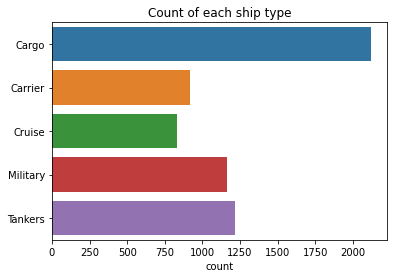

2585

In [10]:
# display count of ship types
plt.title('Count of each ship type')
sns.countplot(y=train_files['ship'].values)
plt.show()
gc.collect()

In [11]:
train_files['ship'].value_counts(normalize=True)


Cargo       0.339091
Tankers     0.194658
Military    0.186660
Carrier     0.146513
Cruise      0.133077
Name: ship, dtype: float64

In [12]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(dtype='int8', sparse=False)
y_train = ohe.fit_transform(train_files['category'].values.reshape(-1,1))

In [13]:
# Since most pre-trained models have a specific input dimension,
# we will need to set the target_size to match the pre-trained model input shape.
# Increasing shape of the images requires more RAM.
def load(what='train', target_size=(224,224)):
    array = []
    if what =='train':
        for file in tqdm(train_files['image'].values):
            img = load_img(os.path.join(path, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    elif what =='test':
        for file in tqdm(test_files['image'].values):
            img = load_img(os.path.join(path, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    gc.collect()
    return np.asarray(array)

In [14]:
# Load Train and Test
X_train = load()
test = load('test')
print(f'train dtype: {X_train.dtype}')
print(f'test dtype: {test.dtype}')
print(f'train shape: {X_train.shape}')
print(f'test shape: {test.shape}')

100%|██████████| 2680/2680 [00:02<00:00, 1168.97it/s]


train dtype: float32
test dtype: float32
train shape: (6252, 224, 224, 3)
test shape: (2680, 224, 224, 3)


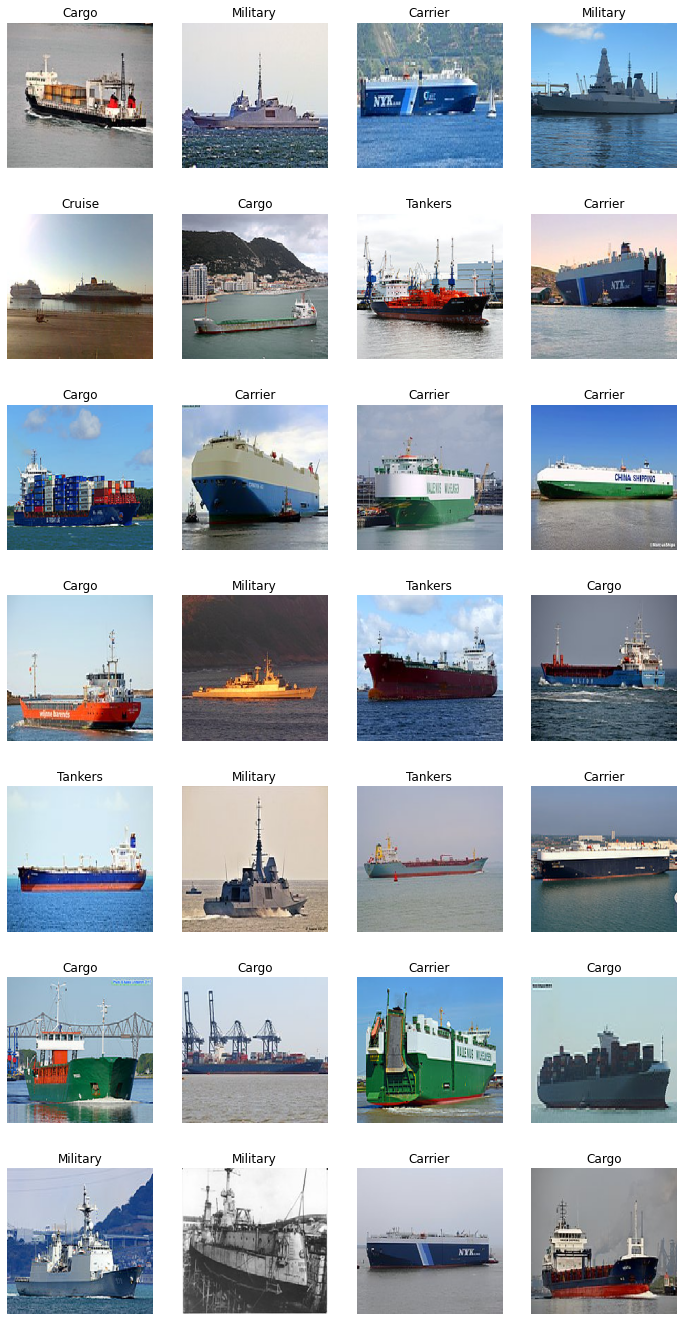

53073

In [15]:
# visualize the top 28 train images
plt.figure(figsize=(12,24))

for i in range(1,29):
    plt.subplot(7,4,i)
    plt.title(f'{train_files["ship"].values[i]}')
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()
gc.collect()

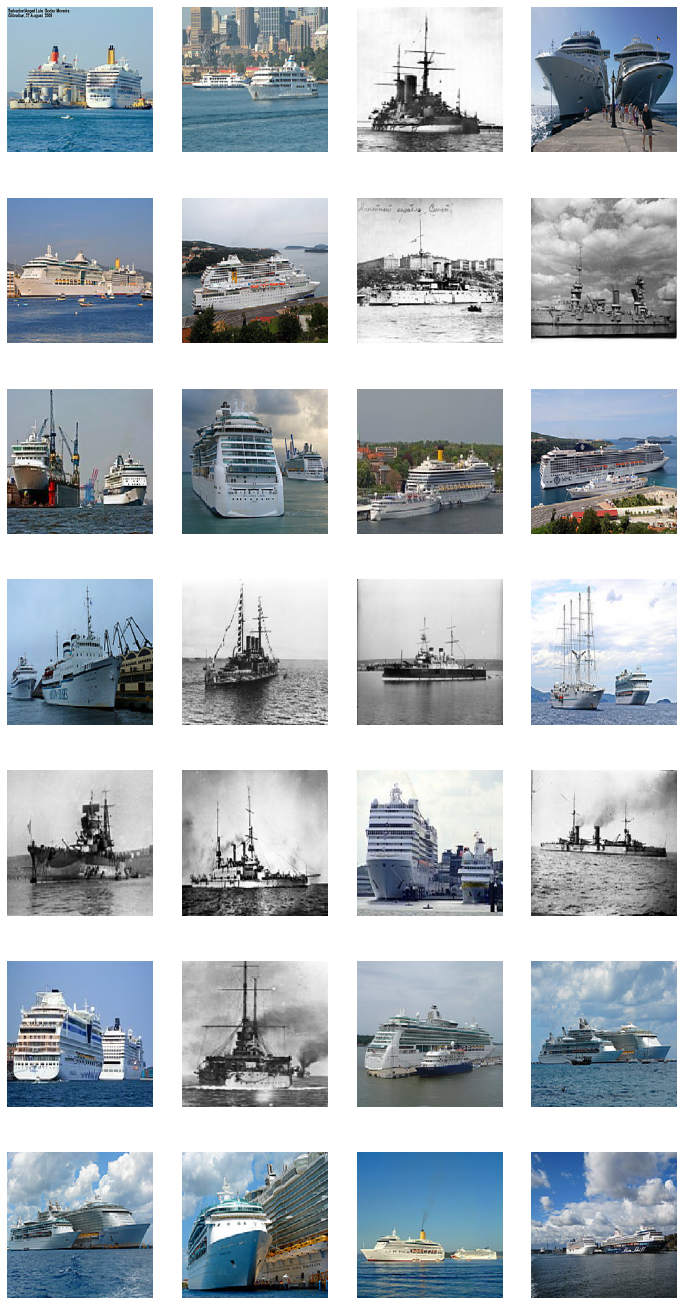

53048

In [18]:
# visualize the top 28 test images
plt.figure(figsize=(12,24))

for i in range(1,29):
    plt.subplot(7,4,i)
    plt.imshow(test[i])
    plt.axis('off')
plt.show()
del test # free up space for training
gc.collect()

In [16]:
# Custom Callbacks for F1 Score
# We need to create a custom callbacks function that calculates f1 score after 
# every epoch to gauge model performance.
class printf1(callbacks.Callback):
    def __init__(self, X_train, y_train):
        super(printf1, self).__init__()
        self.bestf1 = 0
        self.X_train = X_train
        self.y_train = y_train
        
    def on_epoch_end(self, epoch, logs={}):
        pred = np.argmax(self.model.predict(np.array(self.X_train)), axis=1)
        f1 = f1_score(np.argmax(self.y_train, axis=1), pred, average='weighted')
        print("Train F1 Score: {:.4f}".format(f1))
        pred = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        f1 = f1_score(np.argmax(self.validation_data[1], axis=1), pred, average='weighted')
        print("Valid F1 Score: {:.4f}".format(f1))
        return


In [17]:
# to plot training/validation history object
def plt_dynamic(x, vy, ty, ax, colors=['b'], title=''):
    ax.plot(x, vy, 'b', label='Validation Loss')
    ax.plot(x, ty, 'r', label='Train Loss')
    plt.legend()
    plt.grid()
    plt.title(title)
    fig.canvas.draw()
    plt.show()
    gc.collect()

In [18]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    gc.collect()

In [19]:
# Load Pre-trained network and weights (Xception)
# Utilize Keras pre-trained model and weights for faster and 
# more accurate image classification models. Weights were loaded from training on Imagenet dataset.
# make sure internet is enabled in the settings tab to the right
# do not include the last Fully Connected(FC) layer
from keras.applications.xception import Xception
model = Xception(include_top=False, input_shape=(224,224,3))

In [20]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

x = GlobalAveragePooling2D()(model.output)
#x = Dense(6, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# define new model
model = Model(model.inputs, output)
model.save('model.hdf5')
#model.summary()

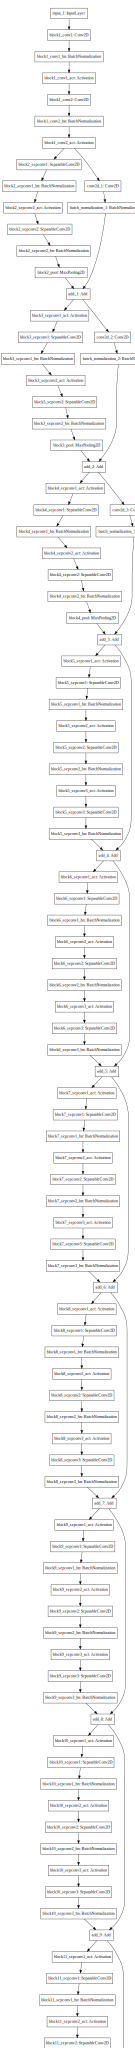

In [21]:
# visualize the Xception model architecture
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [22]:
# Fine-tune Entire Pre-trained Xception Model¶
# 
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    stratify=y_train,
                                                    random_state=2019,
                                                    test_size=0.2)

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
gc.collect()


(5001, 224, 224, 3)
(1251, 224, 224, 3)
(5001, 5)
(1251, 5)


53093

In [24]:
# use ImageDataGenerator to augment training data
from keras.preprocessing.image import ImageDataGenerator
batch_size = 8
epochs = 50

# make sure to keep learning rate low when fine-tuning
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer=adam(lr=0.0001))

datagen = ImageDataGenerator(rotation_range=45, 
                             horizontal_flip=True, 
                             width_shift_range=0.5, 
                             height_shift_range=0.5, 
                             dtype='float32')

datagen.fit(X_train, augment=True, rounds=1, seed=2019)
train_generator = datagen.flow(X_train, y_train, 
                               batch_size=batch_size, 
                               seed=2019)


In [ ]:

f1 = printf1(X_train, y_train)
cp = ModelCheckpoint('best.hdf5', monitor='val_loss', save_best_only=True)
annealer = LearningRateScheduler(lambda x: 1e-4 * 0.95 ** x)

history = model.fit_generator(generator=train_generator, 
                              steps_per_epoch=len(X_train)/batch_size, 
                              validation_data=[X_test, y_test], 
                              callbacks=[cp,f1,annealer],
                              epochs=epochs)


Epoch 1/50
 14/625 [..............................] - ETA: 27:49 - loss: 1.6030 - accuracy: 0.2768